In [ ]:
!pip install pydub 

In [ ]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import math
import IPython.display as ipd
import os
import json
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.layers import Input, Dense, Flatten
import pandas as pd
from pydub import AudioSegment
from scipy.io import wavfile


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!dir

drive  sample_data


In [ ]:
Dataset_path = "/content/drive/MyDrive/Audios_bombas"

In [ ]:
def dividir_sonido(path,duracion_total,duracion_audio,ubicacion):
  sound = AudioSegment.from_file(path)
  frames = int((duracion_total*60)/duracion_audio)
  halfway_point = int(len(sound) // frames)
  point_ini = 0
  point_end = halfway_point
  for i in range(frames):
    audio = sound[point_ini:point_end]
    audio.export(Dataset_path+str(ubicacion)+str(i)+'.wav', format="wav")
    point_ini = halfway_point*(i+1)
    point_end = halfway_point*(i+2)

In [ ]:
filename_falla = Dataset_path + '/Falla/BombaG3_Salvatorianos_mala.m4a'
ub_falla = '/Falla/Audio'

In [ ]:
dividir_sonido(filename_falla,62,5,ub_falla)

In [ ]:
filename_normal = Dataset_path + '/Normal/BombaG2_Salvatorianos_Buena.m4a'
ub_normal = '/Normal/Audio'

In [ ]:
dividir_sonido(filename_normal,60,5,ub_normal)

Leer los audios 

In [ ]:
file_falla = Dataset_path + '/Falla/Audio7.wav'

In [ ]:
file_normal = Dataset_path + '/Normal/Audio7.wav'

Duracion = 5.001 , Frecuencia de Muestreo = 48000 [=] Muestras/Seg, Wav format = int16


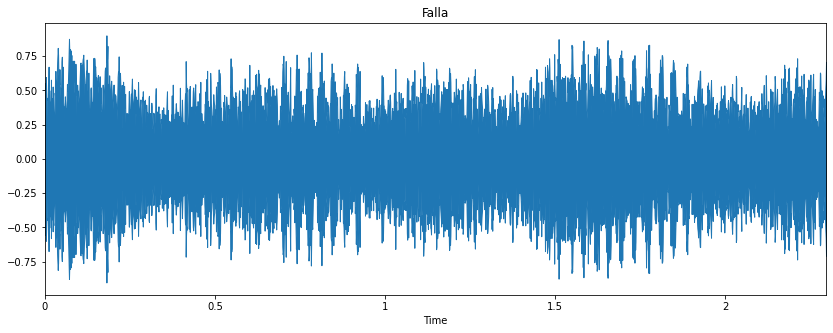

In [ ]:
fs, Audiodata_falla = wavfile.read(file_falla)
print(f'Duracion = {Audiodata_falla.shape[0]/fs} , Frecuencia de Muestreo = {fs} [=] Muestras/Seg' \
      f', Wav format = {Audiodata_falla.dtype}')
plt.figure(figsize=(14,5))
data_falla, sample_rate = librosa.load(file_falla)
librosa.display.waveplot(data_falla, sr=fs)
plt.title("Falla")
ipd.Audio(file_falla)

Duracion = 5.001 , Frecuencia de Muestreo = 48000 [=] Muestras/Seg, Wav format = int16


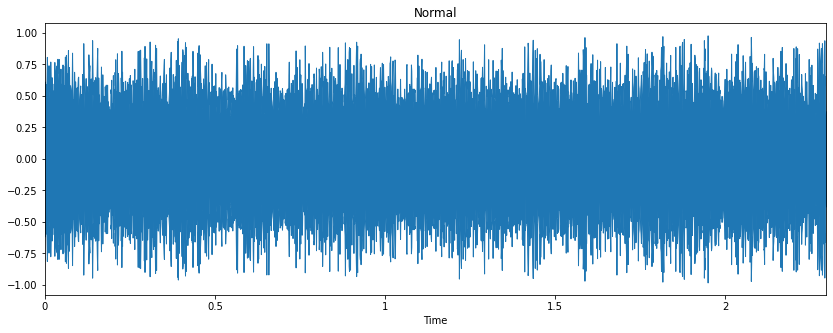

In [ ]:
fs, Audiodata_normal = wavfile.read(file_normal)
print(f'Duracion = {Audiodata_normal.shape[0]/fs} , Frecuencia de Muestreo = {fs} [=] Muestras/Seg' \
      f', Wav format = {Audiodata_normal.dtype}')
plt.figure(figsize=(14,5))
data_normal, sample_rate = librosa.load(file_normal)
librosa.display.waveplot(data_normal, sr=fs)
plt.title("Normal")
ipd.Audio(file_normal)

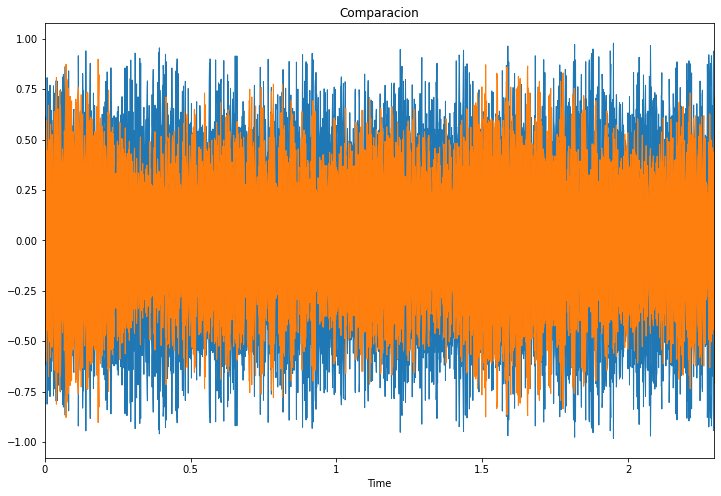

In [ ]:
plt.figure(figsize=(12,8))
librosa.display.waveplot(data_normal, sr=fs)
librosa.display.waveplot(data_falla, sr=fs)
plt.title("Comparacion")
plt.show()

In [ ]:
signal_normal = data_normal
signal_falla = data_falla

In [ ]:
Frame_length = 2048
Hop_length = 512
rms = librosa.feature.rms(signal_normal, frame_length=Frame_length, hop_length=Hop_length)[0]

In [ ]:
FRAME_SIZE = 512
def amplitud_envolvente(signal, frame_size):
  amplitud = []

  for i in range(0, len(signal), frame_size):
    current_amplitud = max(signal[i:i+frame_size])
    amplitud.append(current_amplitud)
  
  return np.array(amplitud)

In [ ]:
ampl = amplitud_envolvente(signal_normal, FRAME_SIZE)
ampl.mean()

0.6915761

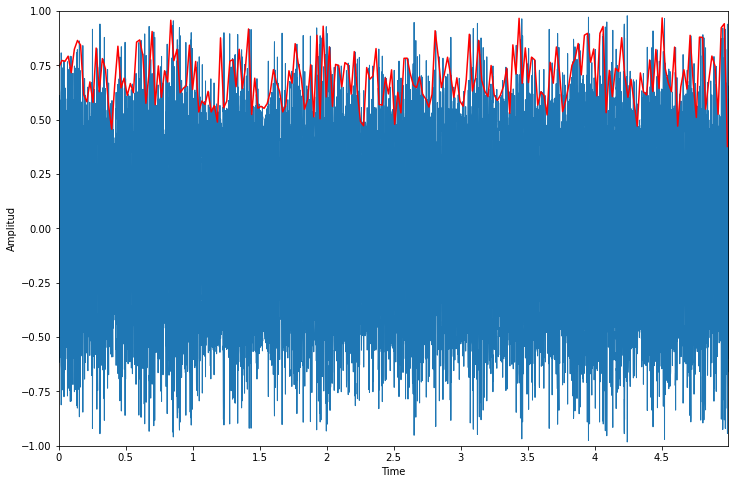

In [ ]:
frames = range(0, ampl.size)
t = librosa.frames_to_time(frames, hop_length=Hop_length)
plt.figure(figsize=(12,8))
librosa.display.waveplot(signal_normal, sr=sample_rate)
plt.plot(t, ampl, color='r')
plt.xlabel("Time")
plt.ylabel("Amplitud")
plt.ylim(-1,1)
plt.show()

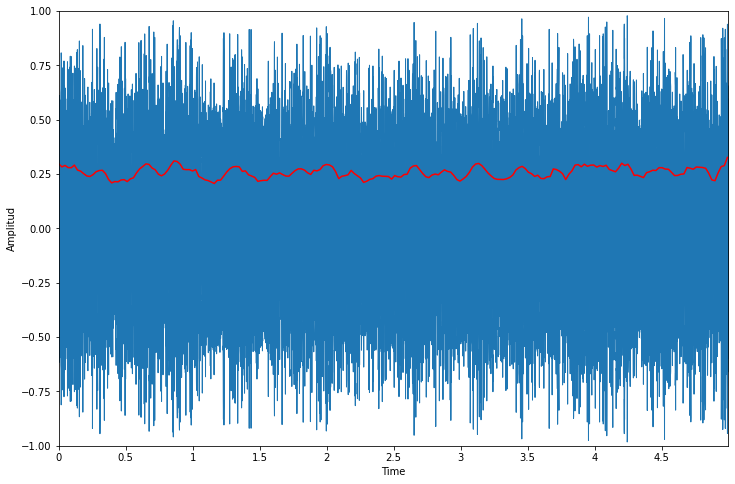

In [ ]:
frames = range(len(rms))
t = librosa.frames_to_time(frames, hop_length=Hop_length)
plt.figure(figsize=(12,8))
librosa.display.waveplot(signal_normal, sr=sample_rate)
plt.plot(t, rms, color='r')
plt.xlabel("Time")
plt.ylabel("Amplitud")
plt.ylim(-1,1)
plt.show()

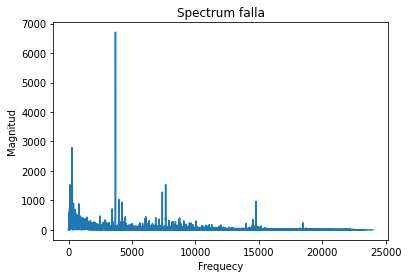

In [ ]:
sr = fs
fft = np.fft.fft(signal_normal)
magnitud = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitud))
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitud = magnitud[:int(len(frequency)/2)]
plt.plot(left_frequency, left_magnitud)
plt.title("Spectrum falla")
plt.xlabel("Frequecy")
plt.ylabel("Magnitud")
plt.show()

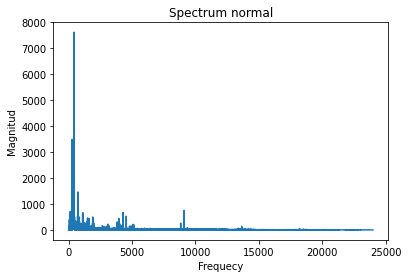

In [ ]:
sr = fs
fft = np.fft.fft(signal_falla)
magnitud = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitud))
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitud = magnitud[:int(len(frequency)/2)]
plt.plot(left_frequency, left_magnitud)
plt.title("Spectrum normal")
plt.xlabel("Frequecy")
plt.ylabel("Magnitud")
plt.show()

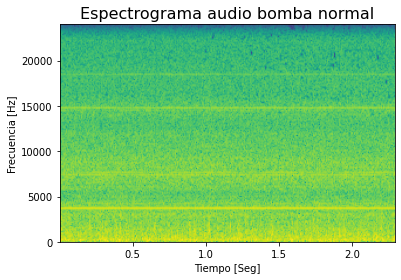

In [ ]:
#Fs, data = wavfile.read(AudioName)
data = signal_normal/(2.**15) # Escalar la señal entre [-1, 1] para un audio de 16 bits
N = 512 #Numero de puntos de la fft
from scipy import signal
Pxx, freqs, bins, im = plt.specgram(data, NFFT=N, Fs=sr,window = signal.blackman(N),noverlap = 128)
plt.title('Espectrograma audio bomba normal',size=16);
plt.ylabel('Frecuencia [Hz]'); plt.xlabel('Tiempo [Seg]');

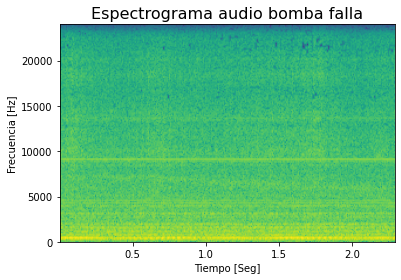

In [ ]:
#Fs, data = wavfile.read(AudioName)
data = signal_falla/(2.**15) # Escalar la señal entre [-1, 1] para un audio de 16 bits
N = 512 #Numero de puntos de la fft
from scipy import signal
Pxx, freqs, bins, im = plt.specgram(data, NFFT=N, Fs=sr,window = signal.blackman(N),noverlap = 128)
plt.title('Espectrograma audio bomba falla',size=16);
plt.ylabel('Frecuencia [Hz]'); plt.xlabel('Tiempo [Seg]');

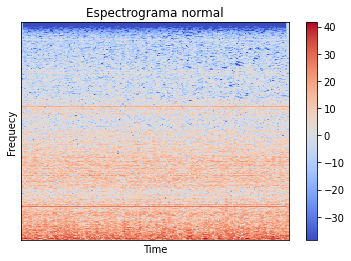

In [ ]:
n_fft = 2048
hop_length = 512
stft = librosa.core.stft(signal_normal, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectogram)
librosa.display.specshow(log_spectogram , sr=fs, hop_length=hop_length)
plt.title("Espectrograma normal")
plt.xlabel("Time")
plt.ylabel("Frequecy")
plt.colorbar()
plt.show()

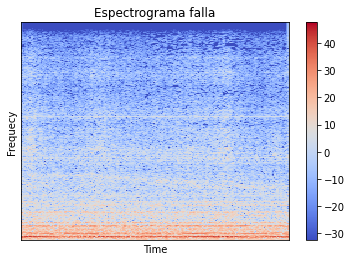

In [ ]:
n_fft = 2048
hop_length = 512
stft = librosa.core.stft(signal_falla, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)
log_spectogram = librosa.amplitude_to_db(spectogram)
librosa.display.specshow(log_spectogram , sr=fs, hop_length=hop_length)
plt.title("Espectrograma falla")
plt.xlabel("Time")
plt.ylabel("Frequecy")
plt.colorbar()
plt.show()

In [ ]:
mfccs_normal = librosa.feature.mfcc(signal_normal, sr=fs)
mfccs_normal.shape

(20, 216)

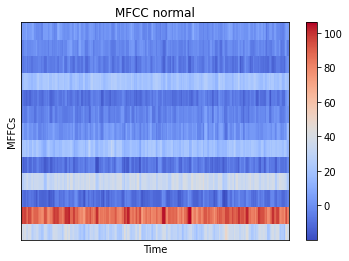

In [ ]:
MFFCs = librosa.feature.mfcc(signal_normal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFFCs , sr=fs, hop_length=hop_length)
plt.title("MFCC normal")
plt.xlabel("Time")
plt.ylabel("MFFCs")
plt.colorbar()
plt.show()

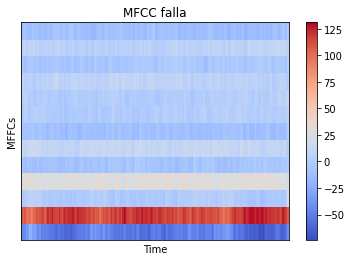

In [ ]:
MFFCs = librosa.feature.mfcc(signal_falla, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFFCs , sr=fs, hop_length=hop_length)
plt.title("MFCC falla")
plt.xlabel("Time")
plt.ylabel("MFFCs")
plt.colorbar()
plt.show()

In [ ]:
##########################
dataset_path = "/content/drive/MyDrive/Audios_bombas"
csv_path = "Caracteristicas_audios.csv"
Sample_rate = 44100
Frame_length = 2048
hop_length = 512
Hop_length = 512
Duration = 5 #Duración de cada audio
samples_per_track = Sample_rate * Duration
num_segments = 1
num_samples_per_segment = int(samples_per_track / num_segments)
n_fft = 1824

def caracteristicas_audios():
  etiqueta = []
  data = []

  rms_promedio = []
  rms_mediana = []
  rms_max = []
  rms_min = []
  rms_desv = []
  sc_promedio = []
  sc_mediana = []
  sc_max = []
  sc_min = []
  sc_desv = []
  amplitud = []
  amplitud_promedio = []
  amplitud_mediana = []
  amplitud_max = []
  amplitud_min = []
  amplitud_desv = []
  delta_promedio = []
  delta_mediana = []
  delta_max = []
  delta_min = []
  delta_desv = []

  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    
    if i is not dataset_path:
      
      for f in filenames:
        file_path = os.path.join(dirpath, f)
        signal, sr = librosa.load(file_path, sr=Sample_rate)

        for s in range(num_segments):
          start_sample = num_samples_per_segment * s #s=0 ->0
          finish_sample = start_sample + num_samples_per_segment #s=0 ->num_samples_per_segment

          dirpath_components = dirpath.split("/") #Genera un arreglo del modo ["Audio","falla"]
          semantic_label = dirpath_components[-1] #Me quedo solo con la categoria: Falla o no falla
          etiqueta.append(semantic_label)
          Etiqueta = pd.DataFrame(etiqueta)
          Etiqueta.rename(columns={0:"Etiqueta"},inplace=True)
                    
          rms = librosa.feature.rms(signal, frame_length=Frame_length, hop_length=Hop_length)[0]
          rms_promedio.append(rms.mean())
          rms_mediana.append(np.median(rms))
          rms_max.append(max(rms))
          rms_min.append(min(rms))
          rms_desv.append(np.std(rms))

          spectral_centroid = librosa.feature.spectral_centroid(signal, sr=sr, n_fft=n_fft, hop_length=Hop_length)[0]
          sc_promedio.append(spectral_centroid.mean())
          sc_mediana.append(np.median(spectral_centroid))
          sc_max.append(max(spectral_centroid))
          sc_min.append(min(spectral_centroid))
          sc_desv.append(np.std(spectral_centroid))

          delta = librosa.feature.delta(signal)
          delta_promedio.append(delta.mean())
          delta_mediana.append(np.median(delta))
          delta_max.append(max(delta))
          delta_min.append(min(delta))
          delta_desv.append(np.std(delta))


          for i in range(0, len(signal), hop_length):
              current_amplitud = max(signal[i:i+hop_length])
              amplitud.append(current_amplitud)
              ampl = np.array(amplitud)
          amplitud_promedio.append(ampl.mean())
          amplitud_mediana.append(np.median(ampl))
          amplitud_max.append(max(ampl))
          amplitud_min.append(min(ampl))
          amplitud_desv.append(np.std(ampl))

          Rms_promedio = pd.DataFrame(rms_promedio)
          Rms_promedio.rename(columns={0:"rms_promedio"},inplace=True)
          Rms_mediana = pd.DataFrame(rms_mediana)
          Rms_mediana.rename(columns={0:"rms_mediana"},inplace=True)
          Rms_max = pd.DataFrame(rms_max)
          Rms_max.rename(columns={0:"rms_max"},inplace=True)
          Rms_min = pd.DataFrame(rms_min)
          Rms_min.rename(columns={0:"rms_min"},inplace=True)
          Rms_desv = pd.DataFrame(rms_desv)
          Rms_desv.rename(columns={0:"rms_desv"},inplace=True)

          Sc_promedio = pd.DataFrame(sc_promedio)
          Sc_promedio.rename(columns={0:"sc_promedio"},inplace=True)
          Sc_mediana = pd.DataFrame(sc_mediana)
          Sc_mediana.rename(columns={0:"sc_mediana"},inplace=True)
          Sc_max = pd.DataFrame(sc_max)
          Sc_max.rename(columns={0:"sc_max"},inplace=True)
          Sc_min = pd.DataFrame(sc_min)
          Sc_min.rename(columns={0:"sc_min"},inplace=True)
          Sc_desv = pd.DataFrame(sc_desv)
          Sc_desv.rename(columns={0:"sc_desv"},inplace=True)

          Amplitud_promedio = pd.DataFrame(amplitud_promedio)
          Amplitud_promedio.rename(columns={0:"amplitud_promedio"},inplace=True)
          Amplitud_mediana = pd.DataFrame(amplitud_mediana)
          Amplitud_mediana.rename(columns={0:"amplitud_mediana"},inplace=True)
          Amplitud_max = pd.DataFrame(amplitud_max)
          Amplitud_max.rename(columns={0:"amplitud_max"},inplace=True)
          Amplitud_min = pd.DataFrame(amplitud_min)
          Amplitud_min.rename(columns={0:"amplitud_min"},inplace=True)
          Amplitud_desv = pd.DataFrame(amplitud_desv)
          Amplitud_desv.rename(columns={0:"amplitud_desv"},inplace=True)

          Delta_promedio = pd.DataFrame(delta_promedio)
          Delta_promedio.rename(columns={0:"delta_promedio"},inplace=True)
          Delta_mediana = pd.DataFrame(delta_mediana)
          Delta_mediana.rename(columns={0:"delta_mediana"},inplace=True)
          Delta_max = pd.DataFrame(delta_max)
          Delta_max.rename(columns={0:"delta_max"},inplace=True)
          Delta_min = pd.DataFrame(delta_min)
          Delta_min.rename(columns={0:"delta_min"},inplace=True)
          Delta_desv = pd.DataFrame(delta_desv)
          Delta_desv.rename(columns={0:"delta_desv"},inplace=True)

            

  datos = pd.concat([Rms_promedio, Rms_mediana, Rms_max, Rms_min, Rms_desv, 
                     Sc_promedio, Sc_mediana, Sc_max, Sc_min, Sc_desv, 
                     Amplitud_promedio, Amplitud_mediana, Amplitud_max, Amplitud_min, Amplitud_desv,
                     Delta_promedio, Delta_mediana, Delta_max, Delta_min, Delta_desv,  
                     Etiqueta], axis=1)
  #print(datos.head(5))

  datos.to_csv(csv_path)      
  #print(datos)

In [ ]:
if __name__=="__main__":
  caracteristicas_audios()

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


# Machine Learning AX.B = Y

In [ ]:
Dataset_path = "/content/drive/MyDrive/Audios/"

In [ ]:
Data = Dataset_path + 'Caracteristicas_audios.csv'

In [ ]:
df = pd.read_csv(Data)

In [ ]:
df.head(10)

,Unnamed: 0,rms_promedio,rms_mediana,rms_max,rms_min,rms_desv,sc_promedio,sc_mediana,sc_max,sc_min,sc_desv,amplitud_promedio,amplitud_mediana,amplitud_max,amplitud_min,amplitud_desv,delta_promedio,delta_mediana,delta_max,delta_min,delta_desv,Etiqueta
0,0,0.009441,0.009409,0.012763,0.006701,0.001082,1180.761988,1147.348182,2799.334073,961.247255,193.410313,0.022640,0.022365,0.038819,0.012752,0.004540,-1.016184e-07,-0.000002,0.004261,-0.003859,0.000920,Audios\Falla
1,1,0.009441,0.009409,0.012763,0.006701,0.001082,1180.761988,1147.348182,2799.334073,961.247255,193.410313,0.022640,0.022365,0.038819,0.012752,0.004540,-1.016184e-07,-0.000002,0.004261,-0.003859,0.000920,Audios\Falla
2,2,0.009441,0.009409,0.012763,0.006701,0.001082,1180.761988,1147.348182,2799.334073,961.247255,193.410313,0.022640,0.022365,0.038819,0.012752,0.004540,-1.016184e-07,-0.000002,0.004261,-0.003859,0.000920,Audios\Falla
3,3,0.009441,0.009409,0.012763,0.006701,0.001082,1180.761988,1147.348182,2799.334073,961.247255,193.410313,0.022640,0.022365,0.038819,0.012752,0.004540,-1.016184e-07,-0.000002,0.004261,-0.003859,0.000920,Audios\Falla
4,4,0.009441,0.009409,0.012763,0.006701,0.001082,1180.761988,1147.348182,2799.334073,961.247255,193.410313,0.022640,0.022365,0.038819,0.012752,0.004540,-1.016184e-07,-0.000002,0.004261,-0.003859,0.000920,Audios\Falla
5,5,0.008375,0.008247,0.012419,0.005546,0.001140,1484.306599,1462.977496,2942.723366,1269.516719,172.403078,0.022364,0.022094,0.045080,0.011899,0.004561,-1.933545e-08,0.000005,0.006838,-0.006106,0.001333,Audios\Falla
6,6,0.008375,0.008247,0.012419,0.005546,0.001140,1484.306599,1462.977496,2942.723366,1269.516719,172.403078,0.022167,0.021884,0.045080,0.011899,0.004566,-1.933545e-08,0.000005,0.006838,-0.006106,0.001333,Audios\Falla
7,7,0.008375,0.008247,0.012419,0.005546,0.001140,1484.306599,1462.977496,2942.723366,1269.516719,172.403078,0.022019,0.021775,0.045080,0.011899,0.004565,-1.933545e-08,0.000005,0.006838,-0.006106,0.001333,Audios\Falla
8,8,0.008375,0.008247,0.012419,0.005546,0.001140,1484.306599,1462.977496,2942.723366,1269.516719,172.403078,0.021904,0.021573,0.045080,0.011899,0.004560,-1.933545e-08,0.000005,0.006838,-0.006106,0.001333,Audios\Falla
9,9,0.008375,0.008247,0.012419,0.005546,0.001140,1484.306599,1462.977496,2942.723366,1269.516719,172.403078,0.021812,0.021499,0.045080,0.011899,0.004554,-1.933545e-08,0.000005,0.006838,-0.006106,0.001333,Audios\Falla


In [ ]:
df.columns.tolist()

['Unnamed: 0',
 'rms_promedio',
 'rms_mediana',
 'rms_max',
 'rms_min',
 'rms_desv',
 'sc_promedio',
 'sc_mediana',
 'sc_max',
 'sc_min',
 'sc_desv',
 'amplitud_promedio',
 'amplitud_mediana',
 'amplitud_max',
 'amplitud_min',
 'amplitud_desv',
 'delta_promedio',
 'delta_mediana',
 'delta_max',
 'delta_min',
 'delta_desv',
 'Etiqueta']

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df['Etiqueta'][df['Etiqueta']== 'Audios\Falla'] = "Falla"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df['Etiqueta'][df['Etiqueta'] != 'Falla'] = "Normal"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.head(5)

,rms_promedio,rms_mediana,rms_max,rms_min,rms_desv,sc_promedio,sc_mediana,sc_max,sc_min,sc_desv,amplitud_promedio,amplitud_mediana,amplitud_max,amplitud_min,amplitud_desv,delta_promedio,delta_mediana,delta_max,delta_min,delta_desv,Etiqueta
0,0.009441,0.009409,0.012763,0.006701,0.001082,1180.761988,1147.348182,2799.334073,961.247255,193.410313,0.02264,0.022365,0.038819,0.012752,0.00454,-1.016184e-07,-0.000002,0.004261,-0.003859,0.00092,Falla
1,0.009441,0.009409,0.012763,0.006701,0.001082,1180.761988,1147.348182,2799.334073,961.247255,193.410313,0.02264,0.022365,0.038819,0.012752,0.00454,-1.016184e-07,-0.000002,0.004261,-0.003859,0.00092,Falla
2,0.009441,0.009409,0.012763,0.006701,0.001082,1180.761988,1147.348182,2799.334073,961.247255,193.410313,0.02264,0.022365,0.038819,0.012752,0.00454,-1.016184e-07,-0.000002,0.004261,-0.003859,0.00092,Falla
3,0.009441,0.009409,0.012763,0.006701,0.001082,1180.761988,1147.348182,2799.334073,961.247255,193.410313,0.02264,0.022365,0.038819,0.012752,0.00454,-1.016184e-07,-0.000002,0.004261,-0.003859,0.00092,Falla
4,0.009441,0.009409,0.012763,0.006701,0.001082,1180.761988,1147.348182,2799.334073,961.247255,193.410313,0.02264,0.022365,0.038819,0.012752,0.00454,-1.016184e-07,-0.000002,0.004261,-0.003859,0.00092,Falla


In [ ]:
df.shape

(1605, 21)

In [ ]:
df.columns.tolist()

['rms_promedio',
 'rms_mediana',
 'rms_max',
 'rms_min',
 'rms_desv',
 'sc_promedio',
 'sc_mediana',
 'sc_max',
 'sc_min',
 'sc_desv',
 'amplitud_promedio',
 'amplitud_mediana',
 'amplitud_max',
 'amplitud_min',
 'amplitud_desv',
 'delta_promedio',
 'delta_mediana',
 'delta_max',
 'delta_min',
 'delta_desv',
 'Etiqueta']

In [ ]:
df.describe()

,rms_promedio,rms_mediana,rms_max,rms_min,rms_desv,sc_promedio,sc_mediana,sc_max,sc_min,sc_desv,amplitud_promedio,amplitud_mediana,amplitud_max,amplitud_min,amplitud_desv,delta_promedio,delta_mediana,delta_max,delta_min,delta_desv
count,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1605.000000,1.605000e+03,1.605000e+03,1605.000000,1605.000000,1605.000000
mean,0.009012,0.008845,0.014586,0.006051,0.001410,1403.471682,1303.398472,3349.256885,1066.783493,383.518591,0.022042,0.021361,0.106092,0.005273,0.006285,5.856996e-09,-4.823212e-07,0.009303,-0.008624,0.001093
std,0.000682,0.000720,0.002650,0.000872,0.000442,318.791294,340.011842,487.755078,282.803090,138.357825,0.000333,0.000112,0.014071,0.001146,0.000986,6.222379e-08,4.638074e-06,0.003451,0.002888,0.000248
min,0.006236,0.005630,0.009167,0.002377,0.000670,811.964439,694.276363,2366.247051,518.343329,142.703957,0.021393,0.020991,0.038819,0.004883,0.004191,-1.641741e-07,-3.726936e-05,0.002707,-0.015320,0.000470
25%,0.008583,0.008386,0.013151,0.005618,0.001182,1173.377102,1058.627706,2827.206579,868.570679,229.586675,0.021719,0.021313,0.094094,0.005062,0.005288,-3.728238e-08,-2.560435e-06,0.005737,-0.010819,0.000920
50%,0.009217,0.009047,0.014388,0.006155,0.001327,1321.952339,1198.265144,3606.014926,994.631239,440.333502,0.022087,0.021397,0.115238,0.005062,0.006324,1.443081e-09,-3.475386e-07,0.010833,-0.009902,0.001018
75%,0.009500,0.009410,0.015189,0.006694,0.001506,1583.594359,1472.384713,3737.593965,1242.574103,490.253262,0.022359,0.021421,0.115238,0.005062,0.007231,4.818644e-08,1.638324e-06,0.011876,-0.005623,0.001339
max,0.010290,0.010025,0.039628,0.008207,0.004940,2873.848080,2853.787661,4090.399826,2482.975624,768.268762,0.022640,0.022365,0.115238,0.012752,0.007717,2.084842e-07,2.652165e-05,0.021563,-0.002938,0.001647


In [ ]:
df2 = df[['rms_promedio','sc_promedio','amplitud_promedio','Etiqueta']]

In [ ]:
!pip install pingouin
import pingouin as pg

In [ ]:
import plotly.express as px

from matplotlib import style

import statsmodels.api as sm
from scipy import stats

plt.style.use('ggplot')

from matplotlib.colors import ListedColormap



from pandas.plotting import andrews_curves
from pandas.plotting import radviz
from pandas.plotting import parallel_coordinates

Text(0.5, 1.0, 'General Statistics of fault pumps')

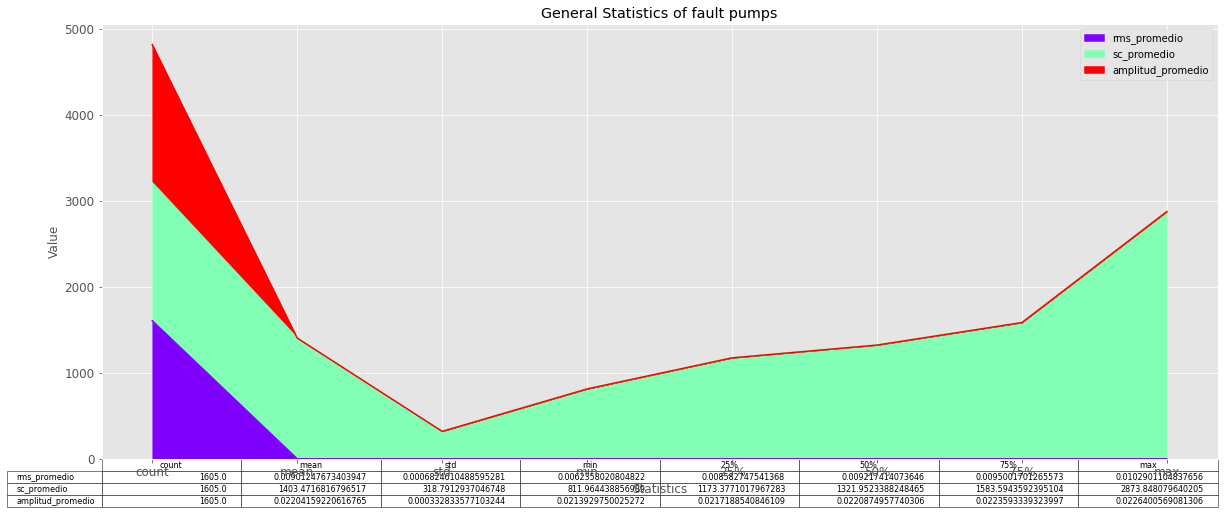

In [ ]:
df2.describe().plot(kind = "area",fontsize=12, figsize = (20,8), table = True,colormap="rainbow")
plt.xlabel('Statistics',)
plt.ylabel('Value')
plt.title("General Statistics of fault pumps")

In [ ]:
df2.columns

Index(['rms_promedio', 'sc_promedio', 'amplitud_promedio', 'delta_promedio',
       'Etiqueta'],
      dtype='object')

In [ ]:
import seaborn as sns

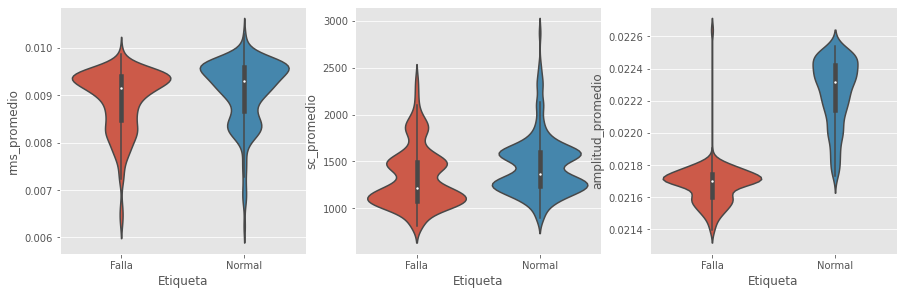

In [ ]:
##Gráfico violin con todas las características
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
sns.violinplot(x='Etiqueta',y='rms_promedio',data=df2)
plt.subplot(2,3,2)
sns.violinplot(x='Etiqueta',y='sc_promedio',data=df2)
plt.subplot(2,3,3)
sns.violinplot(x='Etiqueta',y='amplitud_promedio',data=df2)
pass

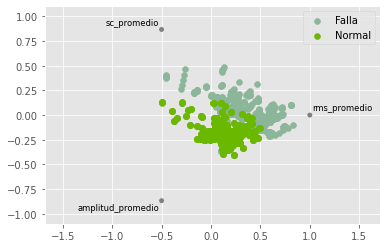

In [ ]:
radviz(df2, "Etiqueta")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px

#import plotly.io as pio
#pio.renderers.default='browser'


#plt.style.use('ggplot')
#%pylab inline
#pylab.rcParams['figure.figsize'] = (10, 6)

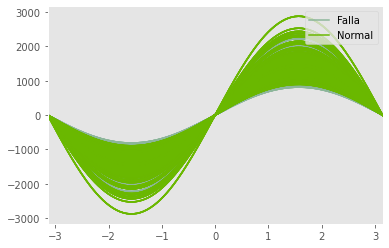

In [ ]:
andrews_curves(df2, "Etiqueta")

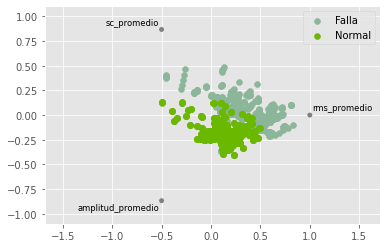

In [ ]:
##Grafica de relación entre las tres variables y las fugas
radviz(df2, "Etiqueta")

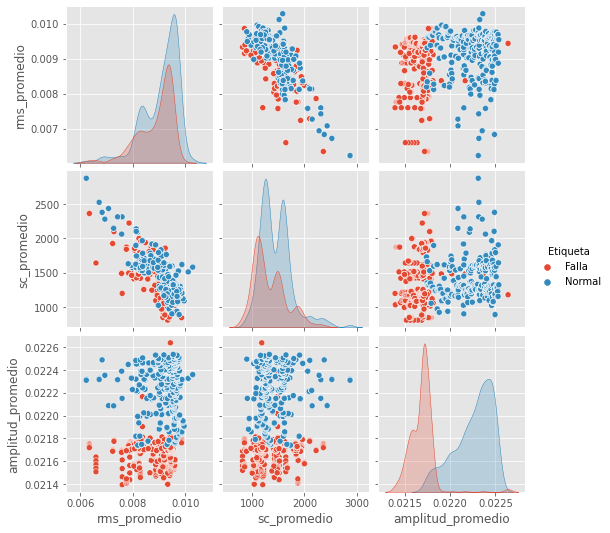

In [ ]:
##Grafica resumen distribuciones de las variables de interes
sns.pairplot(df2,hue='Etiqueta');

In [ ]:
fig2 = px.scatter_3d(
    df2, x='rms_promedio', y='sc_promedio', z='amplitud_promedio', color='Etiqueta',
    title='Grafica fallas bombeos',
    labels={'0': 'rms_promedio', '1': 'sc_promedio', '2': 'amplitud_promedio'}
)
fig2.show()


In [ ]:
x = df.iloc[:,0:20]
y = df.iloc[:,20:]
estandar = StandardScaler()
x_est = estandar.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_est, y, test_size=0.2 )

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
C = [0.1,1,10]
kernel = ['linear','rbf']
gamma = ['scale','auto',0.01,5]

svmrm = SVC()

param_grid = dict(C=C, kernel=kernel, gamma=gamma)
grid = GridSearchCV(estimator=svmrm, param_grid=param_grid, n_jobs=-1, cv=3)
grid.fit(X_train,y_train)

svmrm = grid.best_estimator_

svmrm.fit(X_train,y_train)

In [ ]:
x = df.iloc[:,0:20]

In [ ]:
y = df.iloc[:,20:]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
estandar = StandardScaler()
x_est = estandar.fit_transform(x)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_est, y, test_size=0.2 )

In [ ]:
from sklearn.svm import SVC

In [ ]:
msvc = SVC(kernel='linear')
msvc.fit(X_train, y_train)
y_pred = msvc.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
matrix = confusion_matrix(y_pred,y_test)
matrix

array([[122,   0],
       [  0, 199]])

In [ ]:
import seaborn as sns

array([[122,   0],
       [  0, 199]])

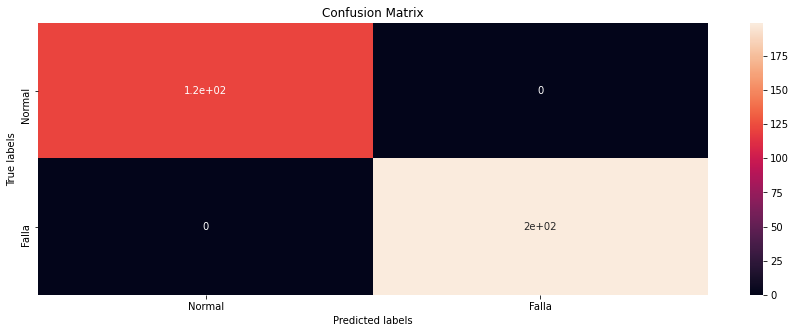

In [ ]:
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Falla']); ax.yaxis.set_ticklabels(['Normal', 'Falla']);
_

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
mdtree = DecisionTreeClassifier(random_state=0)

In [ ]:
mdtree.fit(X_train, y_train)
y_pred = mdtree.predict(X_test)

In [ ]:
matriz = confusion_matrix(y_pred, y_test)
matriz

array([[131,   0],
       [  0, 190]])

## Deep Learning - MFCC

In [ ]:
Dataset_path = "/content/drive/MyDrive/Audios_bombas"

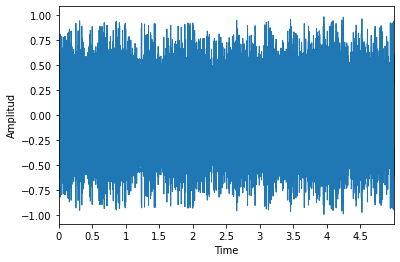

In [ ]:
file = file_normal
signal, sr = librosa.load(file, sr=44100)
librosa.display.waveplot(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitud")
plt.show()

In [ ]:
dataset_path = "/content/drive/MyDrive/Audios_bombas"
json_path = "Data_inst.json"
Sample_rate = 44100
Duration = 5 #Duración de cada audio
samples_per_track = Sample_rate * Duration

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=1024, hop_length=512, num_segments=2):
  data = {
      "mapping": [], #['Normal','Falla']
      "mfcc": [], #[[.,.,.]] Arreglo de MFCC
      "labels": [] #[0, 0, 1...] Son las clases
  }

  num_samples_per_segment = int(samples_per_track / num_segments)
  num_mfcc_expected = math.ceil(num_samples_per_segment / hop_length) #Aproximo el numero de MFCC 

  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

    if dirpath is not dataset_path:

      #Guardo las etiquetas
      dirpath_components = dirpath.split("/") #Genera un arreglo del modo ["Audio","falla"]
      semantic_label = dirpath_components[-1] #Me quedo solo con la categoria: Falla o no falla
      data["mapping"].append(semantic_label) #Guardo las etiquetas en el arreglo Mapping
      print("\nProcessing {}".format(semantic_label))

      #Itero sobre cada clase
      for f in filenames:

        #Proceso cada uno de los audios
        file_path = os.path.join(dirpath, f)
        signal, sr = librosa.load(file_path, sr=Sample_rate)

        #Extraigo MFCC de cada fragmento
        for s in range(num_segments):
          start_sample = num_samples_per_segment * s #s=0 ->0
          finish_sample = start_sample + num_samples_per_segment #s=0 ->num_samples_per_segment

          
          #Extraigo los MFCC pero no de toda la señal sino por cada fragmento
          mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],
                                      sr=sr,
                                      n_fft=n_fft,
                                      n_mfcc=n_mfcc,
                                      hop_length=hop_length)
          
          mfcc = mfcc.T

          #Almaceno los MFCC por segmento si tienen la longitud esperada
          if len(mfcc) == num_mfcc_expected:
            data['mfcc'].append(mfcc.tolist())
            if i==1:
              data['labels'].append(1)
            if i==2:
              data['labels'].append(0)
            print("{}, segment:{}".format(file_path, s))

##Guardamos todo en el archivo json
  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)      


In [ ]:
if __name__=="__main__":
  save_mfcc(dataset_path, json_path, num_segments=2)


Processing Normal
/content/drive/MyDrive/Audios_bombas/Normal/Audio0.wav, segment:0
/content/drive/MyDrive/Audios_bombas/Normal/Audio0.wav, segment:1
/content/drive/MyDrive/Audios_bombas/Normal/Audio1.wav, segment:0
/content/drive/MyDrive/Audios_bombas/Normal/Audio1.wav, segment:1
/content/drive/MyDrive/Audios_bombas/Normal/Audio2.wav, segment:0
/content/drive/MyDrive/Audios_bombas/Normal/Audio2.wav, segment:1
/content/drive/MyDrive/Audios_bombas/Normal/Audio3.wav, segment:0
/content/drive/MyDrive/Audios_bombas/Normal/Audio3.wav, segment:1
/content/drive/MyDrive/Audios_bombas/Normal/Audio4.wav, segment:0
/content/drive/MyDrive/Audios_bombas/Normal/Audio4.wav, segment:1
/content/drive/MyDrive/Audios_bombas/Normal/Audio5.wav, segment:0
/content/drive/MyDrive/Audios_bombas/Normal/Audio5.wav, segment:1
/content/drive/MyDrive/Audios_bombas/Normal/Audio6.wav, segment:0
/content/drive/MyDrive/Audios_bombas/Normal/Audio6.wav, segment:1
/content/drive/MyDrive/Audios_bombas/Normal/Audio7.wav, s

In [ ]:
##Cargamos los MFCC
DATASET_PATH = "/content/drive/MyDrive/Audios_bombas/Data_inst.json"

def load_data(dataset_path):
  with open(dataset_path, "r") as fp:
    data = json.load(fp)

  #Vamos a convertir la lista en arreglo Numpy
  inputs = np.array(data["mfcc"])
  targets = np.array(data["labels"])

  return inputs, targets

#Llamamos los datos
if __name__ == "__main__":
  inputs, targets = load_data(DATASET_PATH)

In [ ]:
inputs[10][10]

array([-119.31433868,  154.31256104,  -70.43795776,   69.24227905,
        -23.19551849,   28.91474915,   -7.96099854,   23.98795319,
        -17.09575272,   -5.28334999,    9.54973984,   11.77800751,
          6.65073586])

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
escalados = scaler.fit(inputs[0])

In [ ]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2)

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(inputs_train.shape[1], inputs_train.shape[2], 1)), #MFFCs vectors
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation=None)
])

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()

history = model.fit(inputs_train, targets_train, 
          validation_data=(inputs_test, targets_test),
          epochs=60,
          batch_size=32)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2808)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               359552    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

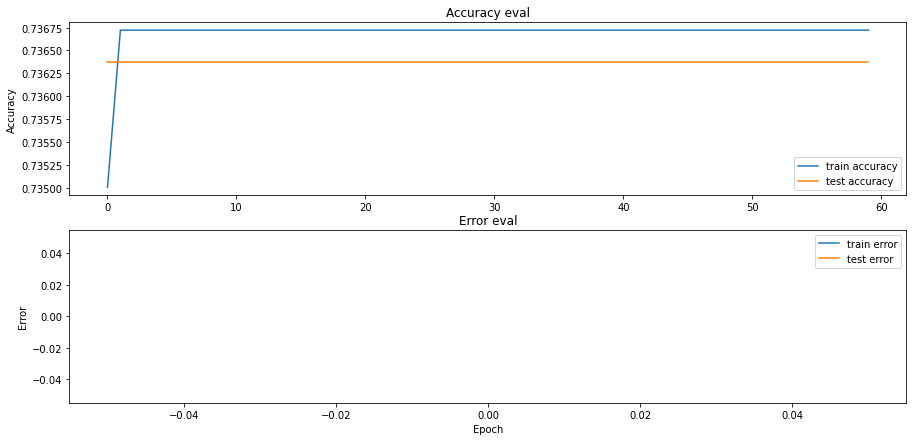

In [ ]:
def plot_history(history):

  fig, axs = plt.subplots(2, figsize=(16,16))

  axs[0].plot(history.history["accuracy"], label = "train accuracy")
  axs[0].plot(history.history["val_accuracy"], label = "test accuracy")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy eval")

  axs[1].plot(history.history["loss"], label = "train error")
  axs[1].plot(history.history["val_loss"], label = "test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error eval")

  fig.set_size_inches(15,7)
  plt.show()

plot_history(history)

**Localización de Fugas - Sonido**

In [ ]:
Dataset_path = "/content/drive/MyDrive/Sonido_fugas/"

In [ ]:
file1 = Dataset_path + '/Localizacion1.wav'

In [ ]:
file2 = Dataset_path + '/Localizacion3.wav'

In [ ]:
file3 = Dataset_path + '/Localizacion4.wav'